In [1]:
import sys
print(sys.version)

3.6.0 (default, Dec 24 2016, 08:01:42) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]


# Все есть объект, что это значит

Очень часто можно услышать такую фразу в отношении Python. Что это значит и какое влияние оказывает на программирование на языке?

In [2]:
# Объявим переменную
num = 10

In [3]:
# На самом деле num - это не имя переменной, ссылающейся на численное значение в памяти, а имя, связанное с объектом.
num.__add__

<method-wrapper '__add__' of int object at 0x10fd1ab10>

In [4]:
# И даже больше
#dir(num)

Все типы в Python "отнаследованы" (на самом деле речь скорее о композиции) от С структуры PyObject:
```
typedef struct _object {
    _PyObject_HEAD_EXTRA
    Py_ssize_t ob_refcnt;
    struct _typeobject *ob_type;
} PyObject;
```
Или от PyVarObject:
```
typedef struct {
    PyObject ob_base;
    Py_ssize_t ob_size; /* Number of items in variable part */
} PyVarObject;
```
Включающей ддополнительно размер данных в низлежащем типе данных.

_typeobject - тип объекта, это структура, посволяющая Питону определять тип объекта в рантайме, содержащая все методы, необходимые для работы с типом. https://github.com/python/cpython/blob/d65c5d2db6b1429a6d61a648836913542766466f/Include/object.h#L346

_PyObject_HEAD_EXTRA - макро, включающей в себя указатели на предыдущий и следующий объекты, живущие в куче (heap).

```
#define _PyObject_HEAD_EXTRA            \
    struct _object *_ob_next;           \
    struct _object *_ob_prev;
```

PyObject_HEAD - макро, включающий в себя определение PyObject, PyObject_VAR_HEAD - макро для PyVarObject. Они используются для определения любого нового типа в Python. Тем самым любой объект в конечном итоге может быть скастован в PyObject.
```
typedef struct PyMyObject {
   PyObject_HEAD
   ...
}
```

Объявления в исходном коде: https://github.com/python/cpython/blob/d65c5d2db6b1429a6d61a648836913542766466f/Include/object.h

Основные типы можно найти в папке `Objects` в исходном коде Python:

* int - Include/longobject.h, Objects/longobject.c 
* str - Include/unicodeobject.h, Objects/unicodeobject.c 
* list - Include/listobject.h, Objects/listobject.c
* class - Include/classobject.h, Objects/classobject.c
* function - Include/funcobject.h, Objects/funcobject.c
* module - Include/moduleobject.h, Objects/moduleobject.c

И другие!

Первое, что важно из утверждения, что все в Питоне есть объект - все может быть присвоено переменной и передано как аргумент в функцию. Не только ф-ии или классы, но и, например, модули.

Также знать это нужно, чтобы понять следующий момент: как работает присваивание.

## Присваивание (Часть 1)

In [17]:
# создаем связь имени переменной foo cо строковым объектом
foo = "Испания"

# связываем имя с новым строковым объектом, строковый объект со строкой "Испания" остался нетронутым.
# В этот момент на куче живет 2 объекта. Один из них сборщик мусора может удалить, но для нас важно не это.
foo = "Бразилия"

При этом в Python имя, привязанное к объекту, используется только в пределах скоупа (scope), в котором имя объявлено. Scope имени определяется блоком питоновского кода. Блоками являются модуль, определение класса, тело функции. Интерпретатор при обращении к переменной ищет ее имя начиная с локального пространства имен, затем у внешних пока не достигает глобального пространства имен.

In [20]:
top_level = 3

def print_result():

    inner_level = 4

    def print_calculation():
        print(top_level * inner_level)

    print_calculation()

print_result()

12


Чуть более сложный пример

In [9]:
country = 'Испания'

countries = []
countries.append(country)

another_list_of_countries = countries
another_list_of_countries.append('Бразилия')

country = 'Россия'

#print(country, countries, another_list_of_countries)

Упс, появилась первая структура данных - list (список). Пожалуй, сначала рассмотрим ее, а потом вернемся к этому примеру.

# Структуры данных

Мы рассмотрим для начала структуры данных, доступные "из коробки"

In [20]:
# built-in структуры данных
list, tuple, dict, set, frozenset

(list, tuple, dict, set, frozenset)

## Список: list

Sequence тип. Позволяет хранить последовательность элементов одного или разного типа. Это не linked list!

In [10]:
# создаем list используя квадратные скобки или ф-ю list
empty_list = []
empty_list = list()
sys.getsizeof(empty_list)

64

In [11]:
# list может содержать любые объекты, внутри Python они хранятся как массив указателей
example_list = [1, True, "a"]
for element in example_list:
    print(element)

1
True
a


In [12]:
list_of_lists = [example_list, example_list]
print(list_of_lists)
sys.getsizeof(list_of_lists)

[[1, True, 'a'], [1, True, 'a']]


80

In [14]:
import sys
from numbers import Number
from collections import Set, Mapping, deque

zero_depth_bases = (str, bytes, Number, range, bytearray)
iteritems = 'items'

def getsize(obj_0):
    """
    Recursively iterate to sum size of object & members.
    http://stackoverflow.com/a/30316760/1288429
    """
    def inner(obj, _seen_ids = set()):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, zero_depth_bases):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, iteritems):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, iteritems)())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)


In [15]:
getsize(list_of_lists)

274

In [24]:
# добавляем элемент в конец списка O(1)
example_list.append("last")
print(example_list)

# добавляем элемент в начало O(n)
example_list.insert(0, "first")
print(example_list)

[1, True, 'a', 'last']
['first', 1, True, 'a', 'last']


In [25]:
benchmark_list = []
%timeit -n10000 benchmark_list.append("last")

10000 loops, best of 3: 251 ns per loop


In [26]:
benchmark_list = []
%timeit -n10000 benchmark_list.insert(0, "first")

10000 loops, best of 3: 6.45 µs per loop


In [12]:
example_list = [0, 1, 2, 3, 4, 5, 6]

# доступ к элементу O(1)
print(example_list[0])
print(example_list[-1])

# Изменение по индексу O(1)
example_list[6] = 10

0
6


In [25]:
# Удаление элемента O(n)
print(example_list)
del example_list[-1]
print(example_list)

['first', 1, True, 'a', 'last']
['first', 1, True, 'a']


In [9]:
# Обращение к несуществующему индексу.
example_list[100]

IndexError: list index out of range

In [26]:
print(example_list[2:])
print(example_list[2:4])
print(example_list[::2])
print(example_list[-1])
print(example_list)
print(example_list[::-1])

[True, 'a']
[True, 'a']
['first', True]
a
['first', 1, True, 'a']
['a', True, 1, 'first']


Продолжение следует...

## Присваивание (Часть 2)

In [31]:
country = 'Испания'

countries = []
countries.append(country)

another_list_of_countries = countries
another_list_of_countries.append('Бразилия')

country = 'Россия'

#print(country, countries, another_list_of_countries)

В Python есть 2 типа объектов. Mutable (изменяемые) и Immutable (неизменяемые).

Любые изменения в mutable объекте видны во всем привязанных к нему именах переменных. Список - пример изменяемого объекта.

Значение неизменяемого объекта поменять нельзя, все что можно сделать - прочитать его и создать новый объект на основе значения старого. Примеры - строки, численные типы и т.д.

Не все так просто, чуть позже на примере кортежа мы разберем, что несмотря на то, что кортеж - immutable объект, не верно считать, что он не изменяется.

Теперь мы готовы посмотреть на передачу объекта как аргумент функции:

In [32]:
def foo(bar):
    # bar в данном случае связь нового имени с объектом, к которому привязан country_list.
    # Этот объект mutable - следовательно ф-я изменит его.
    bar.append("Испания")

country_list = []
foo(country_list)
#print(country_list)

Теперь пример с неизменяемым объектом - строкой:

In [33]:
def foo(bar):
    # bar это имя, которое связано с изначальным строковым объектом, 
    # но это связь имени и объекта в локальном пространстве ф-ии.
    # так как bar в данном случае immutable - все что ф-я может 
    # сделать - изменить связь имени, привязав к новому объекту в своем 
    # локальном неймспейсе. Тем самым не повлияв на country из внешнего неймспейса.
    bar = 'Бразилия'
    #print(bar)

country = 'Испания'
foo(country)
#print(country)

Вывод - важно, что объект в Питоне передается как связь (binding) имени аргумента ф-ии c объектом (**pass-by-object**). По большому счету эта связь - новая ссылка на изначальный объект.

В зависимости от того, изменяемый объект или нет можно понять, способна ли функция изменить его.

## Список: list, продолжение

In [35]:
# при простом присваивании новая переменная ссылается на тот же список
example_list = [1, 2, 3, 4, 5]
another_list = example_list
another_list[0] = 100
# print(example_list)

In [35]:
# копирование списка
example_list = [0, 1, 2, 3, 4, 5]
another_list = example_list[:]
another_list[0] = 100
print(example_list)

[0, 1, 2, 3, 4, 5]


In [36]:
# но вложенные объекты не копируются (shallow copy)
nested_list = [1, 2, 3]
example_list = [nested_list, 1, 2, 3, 4, 5]
another_list = example_list[:]
nested_list.append(4)
print(another_list)

[[1, 2, 3, 4], 1, 2, 3, 4, 5]


In [37]:
# используем ф-ю deepcopy из пакета copy
from copy import deepcopy
nested_list = [1, 2, 3]
example_list = [nested_list, 1, 2, 3, 4, 5]
another_list = deepcopy(example_list)
nested_list.append(4)
print(another_list)

[[1, 2, 3], 1, 2, 3, 4, 5]


### Сортировка

In [24]:
# Сортировка списка
unsorted_list = [2, 1, 5, 4, 3]
unsorted_list.sort()
print(unsorted_list)

[1, 2, 3, 4, 5]


In [25]:
# сортировка in-place
unsorted_list = [2, 1, 5, 4, 3]
print(sorted(unsorted_list))
print(unsorted_list)

[1, 2, 3, 4, 5]
[2, 1, 5, 4, 3]


## Задача - соединить все числа от нуля до 10000 в одну длинную строку


#### ?

## Кортеж: tuple

Так же как и список позволяет хранить последовательность элементов одного или разного типа

* Неизменяемые (Immutable) => защищают данные
* Быстрее списка
* Хешируемые (Hashable)

In [39]:
# создадим пустой tuple используя круглые скобки или ф-ю tuple
empty_tuple = ()
empty_tuple = tuple()
sys.getsizeof(empty_tuple)

48

In [40]:
len(empty_tuple)

0

In [41]:
hash(empty_tuple)

3527539

In [42]:
example_tuple = (1, "a", True)
for element in example_tuple:
    print(element)

1
a
True


In [43]:
len(example_tuple)

3

In [38]:
example_tuple = (1, 2, 3)
print(example_tuple[0])
print(example_tuple[1:])

1
(2, 3)


In [39]:
example_tuple[0] = 2017

TypeError: 'tuple' object does not support item assignment

In [45]:
example_list[200]

IndexError: list index out of range

In [42]:
a = (123)
a
print(type(a))
a = (123, ) # в кортеже с одним элементом запятая обязательна!
print(type(a))

<class 'int'>
<class 'tuple'>


Важно понимать, что **неизменяемым является сам tuple, но не объекты, которые он содержит!**. Например:

In [2]:
first_list = [1, 2]
second_list = [3, 4]
example_tuple = (first_list, second_list)
print(example_tuple)
first_list.append(5)
print(example_tuple)

([1, 2], [3, 4])
([1, 2, 5], [3, 4])


## Словарь: dict

Позволяет хранить пары ключ-значение, для быстрого доступа к значению по ключу. 

In [48]:
# создаем словарь используя фигурные скобки или ф-ю dict
empty_dict = dict()
empty_dict = {}
sys.getsizeof(empty_dict)

288

In [5]:
example_dict = {"a": 1, "b": True, (1, 2, 3): True}

# Добавляем ключ и соответствующее ему значение в словарь O(1)
example_dict["c"] = 4
print(example_dict)

# Поиск значения по ключу O(1)
print(example_dict["c"])

{'a': 1, 'b': True, 'c': 4, (1, 2, 3): True}
4


In [8]:
# Доступ к несуществующему ключу:
print(example_dict["x"])

KeyError: 'x'

In [50]:
# ключом словаря может быть только hashable объект
example_dict[example_list] = True

TypeError: unhashable type: 'list'

Объект является hashable объектом, если он имеет hash-значение, неизменное в процессе его жизни (т.е. у объекта должен быть определен **______hash______()** метод) и объект можно сравнить с другими объектами (**________eq________()** или **________cmp________()** методы). Одинаковые объекты должны иметь одинаковое знаение hash.

Если объект hashable, то он может быть использован как ключ в словаре или член множества (так как эти структуры используют значение hash внутри своей имплементации).

Все immutable встроенные объекты в Python - hashable, mutable контейнеры - нет (списки, словари). Инстансы классов - hashable (их hash значение - их id, то есть адрес в памяти).

In [51]:
# если мы не уверены, что ключ есть в словаре - можно воспользоваться методом get
print(example_dict.get("x"))
print(example_dict.get("x", "default value"))

None
default value


In [52]:
# итерируемся по ключам и значениям - внимание, порядок недетерминирован (до Python 3.6)!
for key, value in example_dict.items():
    print("{}: {}".format(key, value))

a: 1
b: True
c: 4
(1, 2, 3): True


In [53]:
# посмотрим на разницу поиска значения в словаре и списке
search_list = list(range(100000)) 
search_dict = dict.fromkeys(list(range(100000)))

In [54]:
%timeit -n10000 0 in search_list

10000 loops, best of 3: 73.8 ns per loop


In [55]:
%timeit -n10000 0 in search_dict

10000 loops, best of 3: 84.5 ns per loop


In [56]:
%timeit -n1000 99999 in search_list

1000 loops, best of 3: 2.81 ms per loop


In [57]:
%timeit -n10000 99999 in search_dict

10000 loops, best of 3: 126 ns per loop


In [58]:
# объединение словарей
d1 = {"a": 1, "c": 3}
d2 = {"b": 2}
d1.update(d2)
print(d1)

{'a': 1, 'b': 2, 'c': 3}


In [59]:
# копирование
d1 = {"a": 1, "c": 3}
d2 = d1.copy()
d2["a"] = 100
print(d1)
print(d2)
print()

# вложенные не копируются
nested = [1, 2, 3]
d1 = {"a": nested}
d2 = d1.copy()
nested.append(4)
print(d1)
print(d2)
print()

# поэтому опять используем deepcopy
from copy import deepcopy
nested = [1, 2, 3]
d1 = {"a": nested}
d2 = deepcopy(d1)
nested.append(4)
print(d1)
print(d2)

{'a': 1, 'c': 3}
{'a': 100, 'c': 3}

{'a': [1, 2, 3, 4]}
{'a': [1, 2, 3, 4]}

{'a': [1, 2, 3, 4]}
{'a': [1, 2, 3]}


**Задача - есть список элементов. Известно, что у большинства элементов в списке есть пары, то есть их по 2. Но есть некоторое количество элементов, у которых пары нет - их по 1 в списке. Цель - найти эти одиночные элементы.**

Вот решение с помощью словаря:

In [18]:
elements = [2, 1, 5, 2, 4, 3, 1, 4]

solution_dict = {}

# TODO by hand

## Множество: set

Неупорядоченная коллекция, содержащая только уникальные элементы. 

In [81]:
# создадим пустой set c помощью ф-ии set()
empty_set = set()
sys.getsizeof(empty_set)

224

In [21]:
# непустое множество можно также задать фигурными скобками
example_set = {1, 2, 3}

# добавляем элемент в set
example_set.add(4)
print(example_set)

# добавляем уже присутствующий элемент в set - ничего не меняется
example_set.add(1)
print(example_set)

{1, 2, 3, 4}
{1, 2, 3, 4}


In [23]:
# Проверяем наличие значения в множестве O(1)
2 in example_set

True

In [16]:
example_set.add(example_list)

TypeError: unhashable type: 'list'

In [ ]:
another_set = {4, 5, 6}

In [ ]:
print(example_set.difference(another_set)) # различие
print(example_set.union(another_set)) # объединение
print(example_set.intersection(another_set)) # пересечение

In [ ]:
# например, вызов какой-либо ф-ии чат сервиса вернул нам список активных в данный момент пользователей в комнате
active_users = ["Александр", "Михаил", "Ольга"]
# вызов другой ф-ии вернул список администраторов чата
admins = ["Ольга", "Мария"]
# нам нужно найти список активных администраторов и послать им какое-либо уведомление
active_admins = set(active_users).intersection(set(admins))
active_admins

In [43]:
# сеты могут содержать только hashable объекты.
example_set = set()
example_set.add([1, 2, 3])

TypeError: unhashable type: 'list'

**Основная задача, очень часто возникающая на практике. Есть список элементов, нужно оставить только уникальные. Это одна строка с использованием сета:**

In [44]:
elements = ["yellow", "yellow", "green", "red", "blue", "blue", "magenta", "orange", "red"]
set(elements)

{'blue', 'green', 'magenta', 'orange', 'red', 'yellow'}

## frozenset

Так как set может содержать только hashable объекты, а иногда нужен сет сетов - существует frozenset

In [66]:
example_set = set()
example_set.add(frozenset([1,2,3]))
print(example_set)

{frozenset({1, 2, 3})}


## collections

In [46]:
import collections
print([x for x in collections.__dict__.keys() if not x.startswith("_")])

['UserString', 'MutableSequence', 'namedtuple', 'Sized', 'Hashable', 'defaultdict', 'UserList', 'MutableMapping', 'Generator', 'AsyncIterable', 'Container', 'ByteString', 'OrderedDict', 'MappingView', 'MutableSet', 'Callable', 'AsyncIterator', 'Mapping', 'Iterable', 'Iterator', 'ValuesView', 'ChainMap', 'Sequence', 'deque', 'Counter', 'Set', 'KeysView', 'ItemsView', 'Coroutine', 'UserDict', 'abc', 'Awaitable']


In [47]:
# counter
counter = collections.Counter([1,2,3,4,1,2,1,1,1])
for elem, count in counter.most_common(3):
    print("{}: {} times".format(elem, count))

1: 5 times
2: 2 times
3: 1 times


In [48]:
# defaultdict
default_dict = collections.defaultdict(int)
default_dict["not_exists"]

0

In [49]:
# namedtuple
import math
Point = collections.namedtuple('Point', ['x', 'y'])
point1 = Point(0, 0)
point2 = Point(3, 4)
distance = math.sqrt((point2.x - point1.x)**2 + (point2.y - point1.y)**2)
distance

5.0

## queue

In [50]:
import queue

print("Queue:", queue.Queue.__doc__)
print()
print("PriorityQueue:", queue.PriorityQueue.__doc__)
print()
print("LifoQueue:", queue.LifoQueue.__doc__)

Queue: Create a queue object with a given maximum size.

    If maxsize is <= 0, the queue size is infinite.
    

PriorityQueue: Variant of Queue that retrieves open entries in priority order (lowest first).

    Entries are typically tuples of the form:  (priority number, data).
    

LifoQueue: Variant of Queue that retrieves most recently added entries first.


* Queue
* PriorityQueue
* LifoQueue

Разберем позже, когда будем говорить о многопоточности, так как доступ к этим структурам синхронизирован.

## heapq

In [51]:
import heapq
from random import shuffle

heap = []
data = list(range(10))
shuffle(data)

for i in data:
    heapq.heappush(heap, i)

# Порядок элементов будет совсем не случайным, как может показаться.
# Элементы идут не строго по порядку, но удовлетворяют правилу:
# heap[k] <= heap[2*k+1] and heap[k] <= heap[2*k+2] для всех элементов.
print(heap)
for k in range(3):
    print(heap[k] <= heap[2*k+1] and heap[k] <= heap[2*k+2])
print("...")
print()

for i in range(10):
    print(heapq.heappop(heap))

[0, 1, 3, 2, 4, 7, 9, 5, 8, 6]
True
True
True
...

0
1
2
3
4
5
6
7
8
9


### Другие структуры данных

* Связанные списки
* Деревья
* Графы
* ...

Если вам нужна реализация какой-то конкретно структуры данных - скорее всего вы найдете готовую open-source реализацию.

## Анализ сложности, визуализация некоторых операций

In [10]:
%matplotlib inline
plotting = True
try:
    import matplotlib
    import seaborn as sbn
    import matplotlib.pyplot as plt
except ImportError:
    # Не удалось импортировать модуль, не будем рисовать.
    plotting = False
    print("can't import plotting tools")
else:
    # задаем ширину и высоту графиков
    matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [11]:
def draw_plot(labelY, dataX, dataY):
    plt.plot(dataX, dataY, 'ro')
    plt.ylabel(labelY)
    plt.xlabel("elements")
    plt.show()

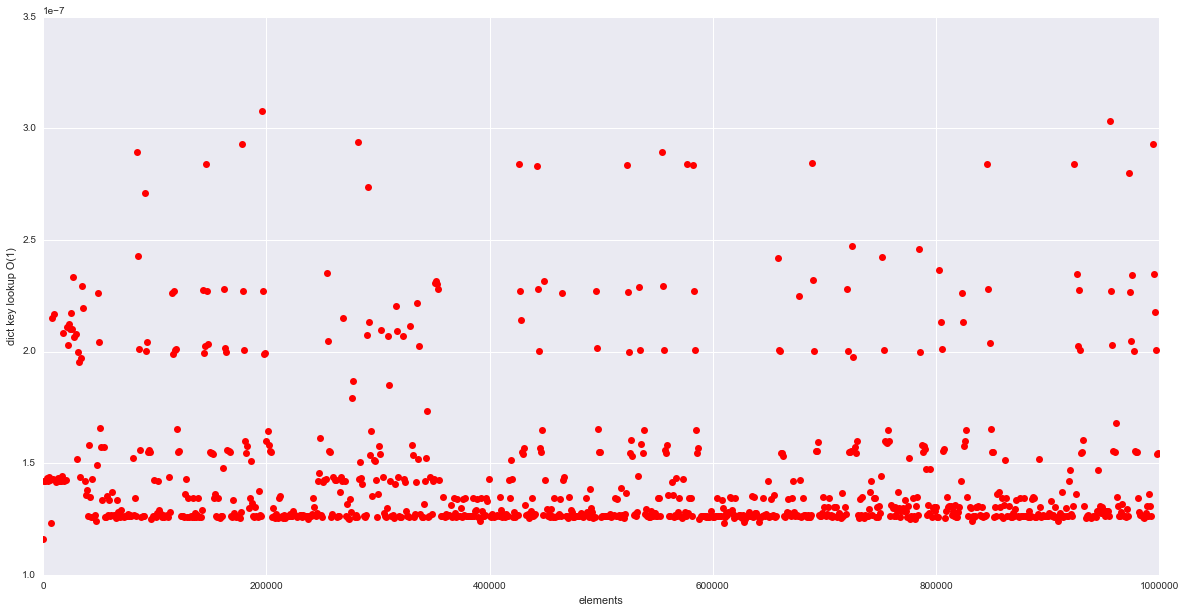

In [55]:
import random

if plotting:
    elements = range(1000000)[::1000]
    measurements = []
    example_dict = {}

    for elem in elements:
        for i in range(len(example_dict), elem+1):
            example_dict[i] = True
        num = random.randint(0, elem)
        result = %timeit -n1000 -q -o example_dict[num]
        measurements.append(result.best)

    draw_plot("dict key lookup O(1)", elements, measurements)
else:
    print("plotting unavailable")

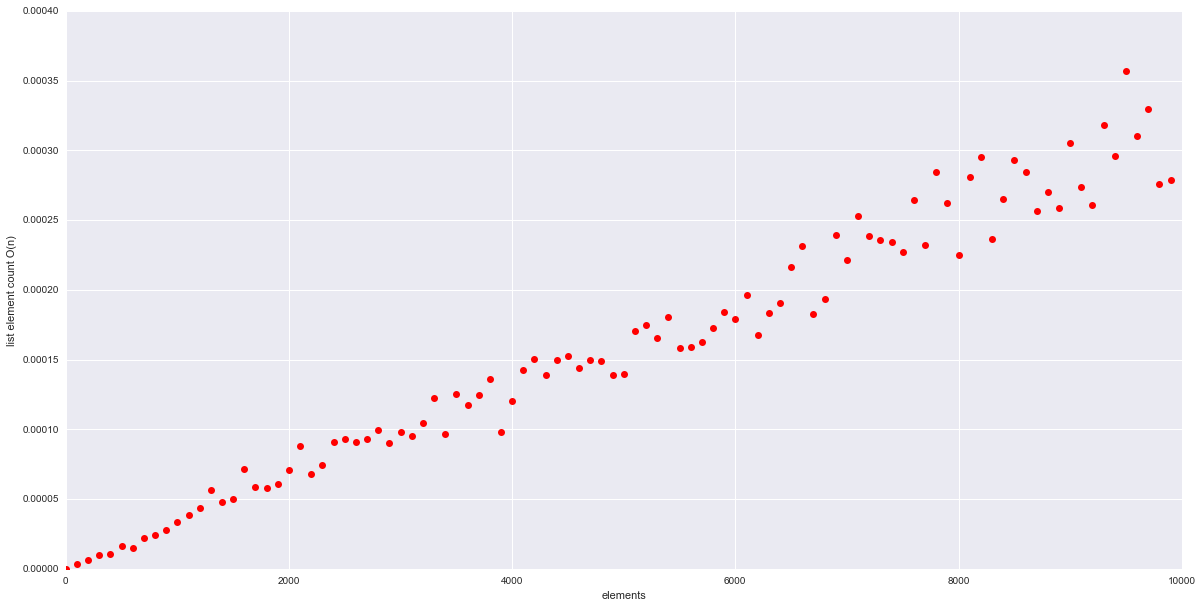

In [56]:
import random

if plotting:
    elements = range(10000)[::100]
    measurements = []

    for elem in elements:
        example_list = []
        for i in range(elem):
            example_list.append(random.randint(0, elem))
        num = random.randint(0, elem)
        result = %timeit -n1000 -q -o example_list.count(num)
        measurements.append(result.best)

    draw_plot("list element count O(n)", elements, measurements)

else:
    print("plotting unavailable")

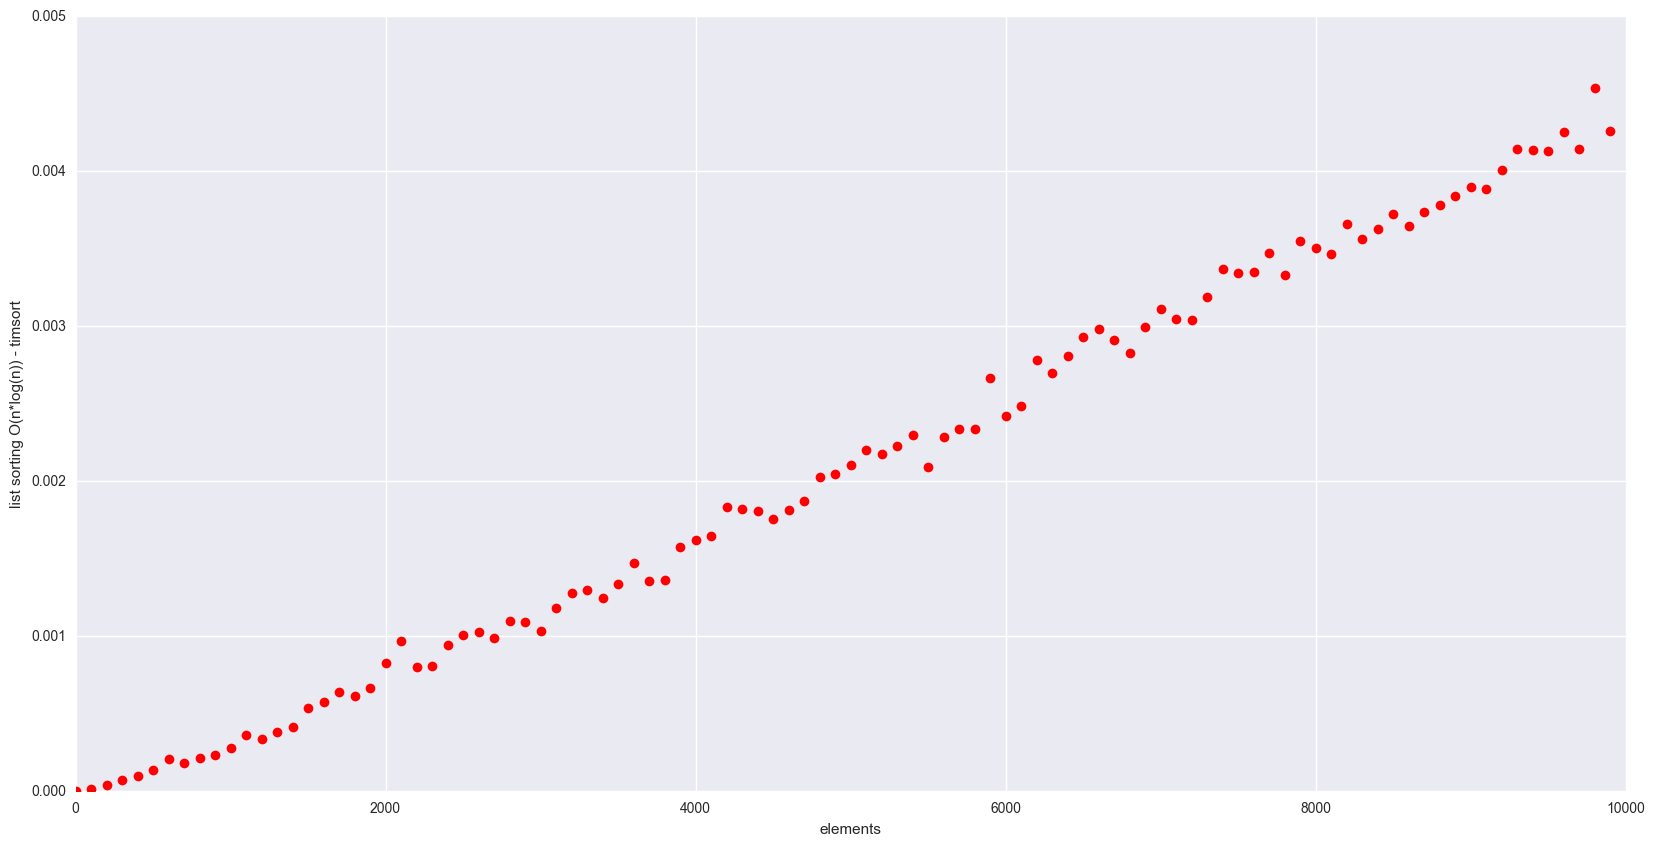

In [12]:
import random

if plotting:
    elements = range(10000)[::100]
    measurements = []
    example_list = []
    for elem in elements:
        for i in range(len(example_list), elem):
            example_list.append(random.randint(0, elem))
        result = %timeit -n50 -q -o sorted(example_list)
        measurements.append(result.best)

    draw_plot("list sorting O(n*log(n)) - timsort", elements, measurements)
else:
    print("plotting unavailable")

Ссылки:

https://docs.python.org/3/tutorial/datastructures.html

https://pymbook.readthedocs.io/en/latest/datastructure.html

http://interactivepython.org/runestone/static/pythonds/index.html

## Немного практики в завершение

In [3]:
from so import get_best_answer
from IPython.core.display import display, HTML

In [4]:
answer = get_best_answer("What is Python GIL")
if answer:
    display(HTML(answer["body"]))
else:
    print("Answer not found")